# Autoregressive heteroskedasticiy dynamic factor analysis (ARH DFA) model in `numpyro`

At each time $t$, $y_t$ is a matrix of $L$ by $H$ with the observed loss difference for one model pair in each location $l = 1, \ldots, L$ and each horizon $h=1,\cdots, H$. That is, $y_{t,l} is a vector of length $H$. We organize the observed data across $T$ time points into a $T$ by $L$ by $H$ array $y$. We first create model only considering time points and locations and assume that the mean of loss differences is the same for all horizons at each location at time $t$. Then, to include the horizon in the model, we assume that the residual errors are independent across time points and locations, but do not cross the horizon. So we first introduce model without considering horizons, then extend it by adding horizons. 

## model without horizons
The model writes $y_t$ as the sum of an intercept, $\theta$, and a linear combination of latent factors at each time point. The latent factors in turn follow an AR(p) process, with the autoregression parameters shared across all factors. The intercept $\theta$ represents the mean forecast skill and is our parameter of interest.

We formulate this model as a linear Gaussian state space model, though for notational and computational convenience our exposition diverges slightly from the usual set up where the state is a column vector that right-multiplies transition and observation matrices. In our formulation, the state $z_t$ is a $p$ by $n_F$ array, where $p$ is the order of the AR process and $n_F$ is the number of latent factors. Row $i$ of $z_t$, denoted by $z_{t,i,\cdot}$, represents the latent factor values at time $t-i+1$, with values $z_{t,i,j}$ corresponding to the value of the $j$'th latent factor at time $t-i+1$.

The latent factors change over time according to the following process:

\begin{align*}
z_{0,i,j} &\stackrel{\text{i.i.d.}}{\sim} \text{Normal}(0, 1), \text{ $i = 1, \ldots, p$, $j = 1, \ldots, n_F$} \\
z_t \mid z_{t-1}, \phi, \eta_t &= \begin{bmatrix}
        \phi_1 & \cdots & \phi_{p-1} & \phi_p \\
        1      & \cdots & 0      & 0 \\
        \vdots & \ddots & \vdots & \vdots \\
        0 & \cdots & 1 & 0 \end{bmatrix} z_{t-1} + 
    \begin{bmatrix} \eta_{t,1} & \cdots & \eta_{t,n_F} \\
                    0          & \cdots & 0            \\
                    \vdots     & \ddots & \vdots       \\
                    0          & \cdots & 0            \end{bmatrix} \\
\phi_1, \ldots, \phi_p &\stackrel{\text{i.i.d.}}{\sim} \text{Unif}(0, 1) \\
\eta_{t,1}, \ldots, \eta_{t,n_F} \mid \sigma_\eta &\stackrel{\text{i.i.d.}}{\sim} \text{Normal}(0, \sigma_\eta) \\
\sigma_\eta &\sim \text{Exponential}(1)
\end{align*}

Conditional on the latent factors, the model for the observed data is as follows:

\begin{align*}
y_t \mid z_t, H, \varepsilon_t &= \theta + z_{t, 1, \cdot} H^\top + \varepsilon_t \\
\theta &\sim \text{Normal}(0, 1) \\
H_1, ..., H_L &\stackrel{\text{i.i.d.}}{\sim} \text{Dirichlet}(\mathbf{1}_D) \\
\varepsilon_t \mid \theta, \sigma_\varepsilon &\sim \text{MVN}(0, \text{diag}(\sigma_\varepsilon)) \\
\sigma_{\varepsilon,1}, \ldots, \sigma_{\varepsilon,L} &\stackrel{\text{i.i.d.}}{\sim} \text{Exponential}(0,1)
\end{align*}

Here, $H_l$ denotes row $l$ of the $L$ by $n_F$ factor loading matrix $H$.

### - An AR(q) process for the logarithm of the variance of the latent factor error term
In the above DFA model, $\sigma_{\eta} \sim Exponential(1)$. ARCH model describes the variance of the current error term as a function of the previous time periods' error terms, often the variance is related to the squares of the previous error term, $\sigma_{\eta,t} = \alpha_0 + \alpha_1 \eta_{t-1}^2 + \alpha_2 \eta_{t-2}^2 + \cdots + \alpha_q \eta_{t-q}^2$. However, we want to make our model is the variance of the current error term as a function of the variance of the previous time periods' error terms and another noise, $\sigma_{\eta,t} = \alpha_0 + \alpha_1 \sigma_{\eta,t-1}^2 + \alpha_2 \sigma_{\eta,t-2}^2 + \cdots + \alpha_q \sigma_{\eta,t-q}^2 + \nu_t$. And since $\sigma_{\eta,t}$ is the variance, it must always be greater than 0. And take the log on $\sigma_{\eta,t}$ to satisfy the condition, 
\begin{align}
log(\sigma_{\eta,t}) = \alpha_0 + \alpha_1 log(\sigma_{\eta,t-1}) + \alpha_2 log(\sigma_{\eta,t-2}) + \cdots + \alpha_q log(\sigma_{\eta,t-q}) + \nu_t.
\end{align}

In our formulation, the $\sigma_{\eta,t}$ is a $q$ vector, where $q$ is the order of the AR process. 

\begin{align*}
\sigma_{\eta0,k} &\stackrel{\text{i.i.d.}}{\sim} \text{Normal}(0, 1), \text{ $k = 1, \ldots, q$} \\
log(\sigma_{\eta,t}) \mid log(\sigma_{\eta,t-1}), \alpha, \nu_t &= \alpha_0 + \begin{bmatrix}
        \alpha_1 & \cdots & \alpha_{q-1} & \alpha_q \\
        1      & \cdots & 0      & 0 \\
        \vdots & \ddots & \vdots & \vdots \\
        0 & \cdots & 1 & 0 \end{bmatrix} log(\sigma_{\eta,t-1}) + 
    \begin{bmatrix} \nu_{t} \\
                    0  \\
                    \vdots  \\
                    0 \end{bmatrix} \\
\alpha_0 &= \mu(1-\alpha_1-\cdots -\alpha_q) \quad \quad \text{Here, }\mu = \frac{1}{T} \sum_{t=1}^T log(\sigma_{\eta,t})\\
\alpha_1, \ldots, \alpha_q &\stackrel{\text{i.i.d.}}{\sim} \text{Unif}(0, 1) \\
\nu_t &\sim \text{Normal}(0,\sigma_{\nu})  \\
\sigma_{\nu} &= c \text{ or } \sim Exponential(d)
\end{align*}




### - Link two errors, $\epsilon_t$ and $\eta_t$

When generating simulation data, we want the errors close to zero for most periods and want large errors for some periods. 
We use the AR(q) process for the logarithm of the variance of the latent factor error term to ensure that the error could be different at different time points. However, our model has two different error terms, $\epsilon_t$ and $\eta_t$. So even though we make different errors at different time points for $\eta_t$, it won't have much effect if these two error terms are in different directions. Therefore, we want to make these two errors in the same direction and follow this: Use linear regression between $\sigma_{\epsilon}$ and $\sigma_{\eta}$
$$\log(\sigma_{\varepsilon,t}) \mid \sigma_{\eta,t}, \beta_{0, \sigma_{\varepsilon}}, \beta_{1, \sigma_{\varepsilon}} \sim N(\beta_{0, \sigma_{\varepsilon}} + \beta_{1, \sigma_{\varepsilon}} \log(\sigma_{\eta,t}), \sigma_{\zeta})$$


## Add horizons

Now, we add horizon terms into the model. As mentioned before, we assume that the mean of the loss differences is the same for all horizons at each location, so we follows the same fomula for latent factor and the AR(q) process for the logarithm of the variance of the latent factor error term. Therefore, $\mathbb{J}_H$ is added to the mean of the loss differences so that each horizon follows the same mean of the loss differences. However, think carefully about the error, $\Omega_{t,l}^{1/2} \varepsilon_{obs,t,l}$.  

\begin{align*}
\mathbf{y_{t,l}} \mid z_t, H, \Omega_{t,l} &= (\theta + z_{t}^\top H_l) \mathbb{J}_H  + \Omega_{t,l}^{1/2} \varepsilon_{obs,t,l}\\
\theta &\sim \text{Cauchy}(0, 1) \\
z_t &= (z_{t,1}, \ldots, z_{t, n_F})^\top \\
z_{0, j} &\sim N(0,1), \quad j=1,\cdots,n_F \\
z_{t,j} \mid z_{t-p:t-1, j} &\sim N(\sum_{i=1}^p \phi_i z_{t-i,j}, \sigma_{\eta,t}) \\
\phi_i &\sim Unif(0,1) \text{  or  }  Unif(-1,1), \quad i = 1,\cdots, p\\
H_1, ..., H_L &\stackrel{\text{i.i.d.}}{\sim} \text{Dirichlet}(\mathbf{1}_D) \\
\\
\varepsilon_{obs,t,l}  &\sim \text{Normal}(0, 1) \\
\Omega_{t,l} &= \sigma_{\varepsilon,t}^{2}*\sigma_{\varepsilon,l}^{2}*\Sigma_{\varepsilon,h} \\
log(\sigma_{\eta,t}) \mid \sigma_{\eta,t-1:t-q}, \alpha_0, \ldots, \alpha_q, \nu_t &= \alpha_0 + \sum_{k=1}^q \alpha_k log(\sigma_{\eta,t-k}) + \nu_t \\
\alpha_0 &= \mu_{\sigma_\eta} (1 - \sum_{k=1}^q \alpha_k) \\
\mu_{\sigma_\eta} &\sim N(0,1) \\
\alpha_k &\sim Unif(0,1), \, k = 1, \ldots, q \\
\nu_t &\sim Normal(0,\sigma_{\nu})\\
\sigma_{\nu} &\sim HalfNormal(0,1) \\
\log(\sigma_{\varepsilon,t}) \mid \sigma_{\eta,t}, \beta_{0, \sigma_{\varepsilon}}, \beta_{1, \sigma_{\varepsilon}} &\sim N(\beta_{0, \sigma_{\varepsilon}} + \beta_{1, \sigma_{\varepsilon}} \log(\sigma_{\eta,t}), \sigma_{\zeta}) \\
\beta_{0, \sigma_{\varepsilon}}, \beta_{1, \sigma_{\varepsilon}} &\sim N(0, 1) \\
\sigma_{\zeta} &\sim HalfNormal(0,1)\\ 
%\text{ OR } \log(\sigma_{\varepsilon,t}) &\sim N(..., ...) \\
\sigma_{\varepsilon,l} &\stackrel{\text{i.i.d.}}{\sim} \text{Exponential}(0,1)\\
\Sigma_{\varepsilon,h} =& diag(\sigma_h)\mathbf{R} diag(\sigma_h) \\
&= diag(\sigma_h)\mathbf{L} \mathbf{L}^\top diag(\sigma_h) \\
&= \Sigma_{\varepsilon,h}^{1/2} (\Sigma_{\varepsilon,h}^{1/2})^\top \text{ where } \Sigma_{\varepsilon,h}^{1/2} = diag(\sigma_h)\mathbf{L}
\end{align*}


In [1]:
import os   
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date

import jax
import jax.numpy as jnp

from archdfa import ARCHDFA

import arviz as az
import matplotlib.pyplot as plt


/Users/dongahkim/anaconda3/envs/forecastskill/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(100, 10, 5)


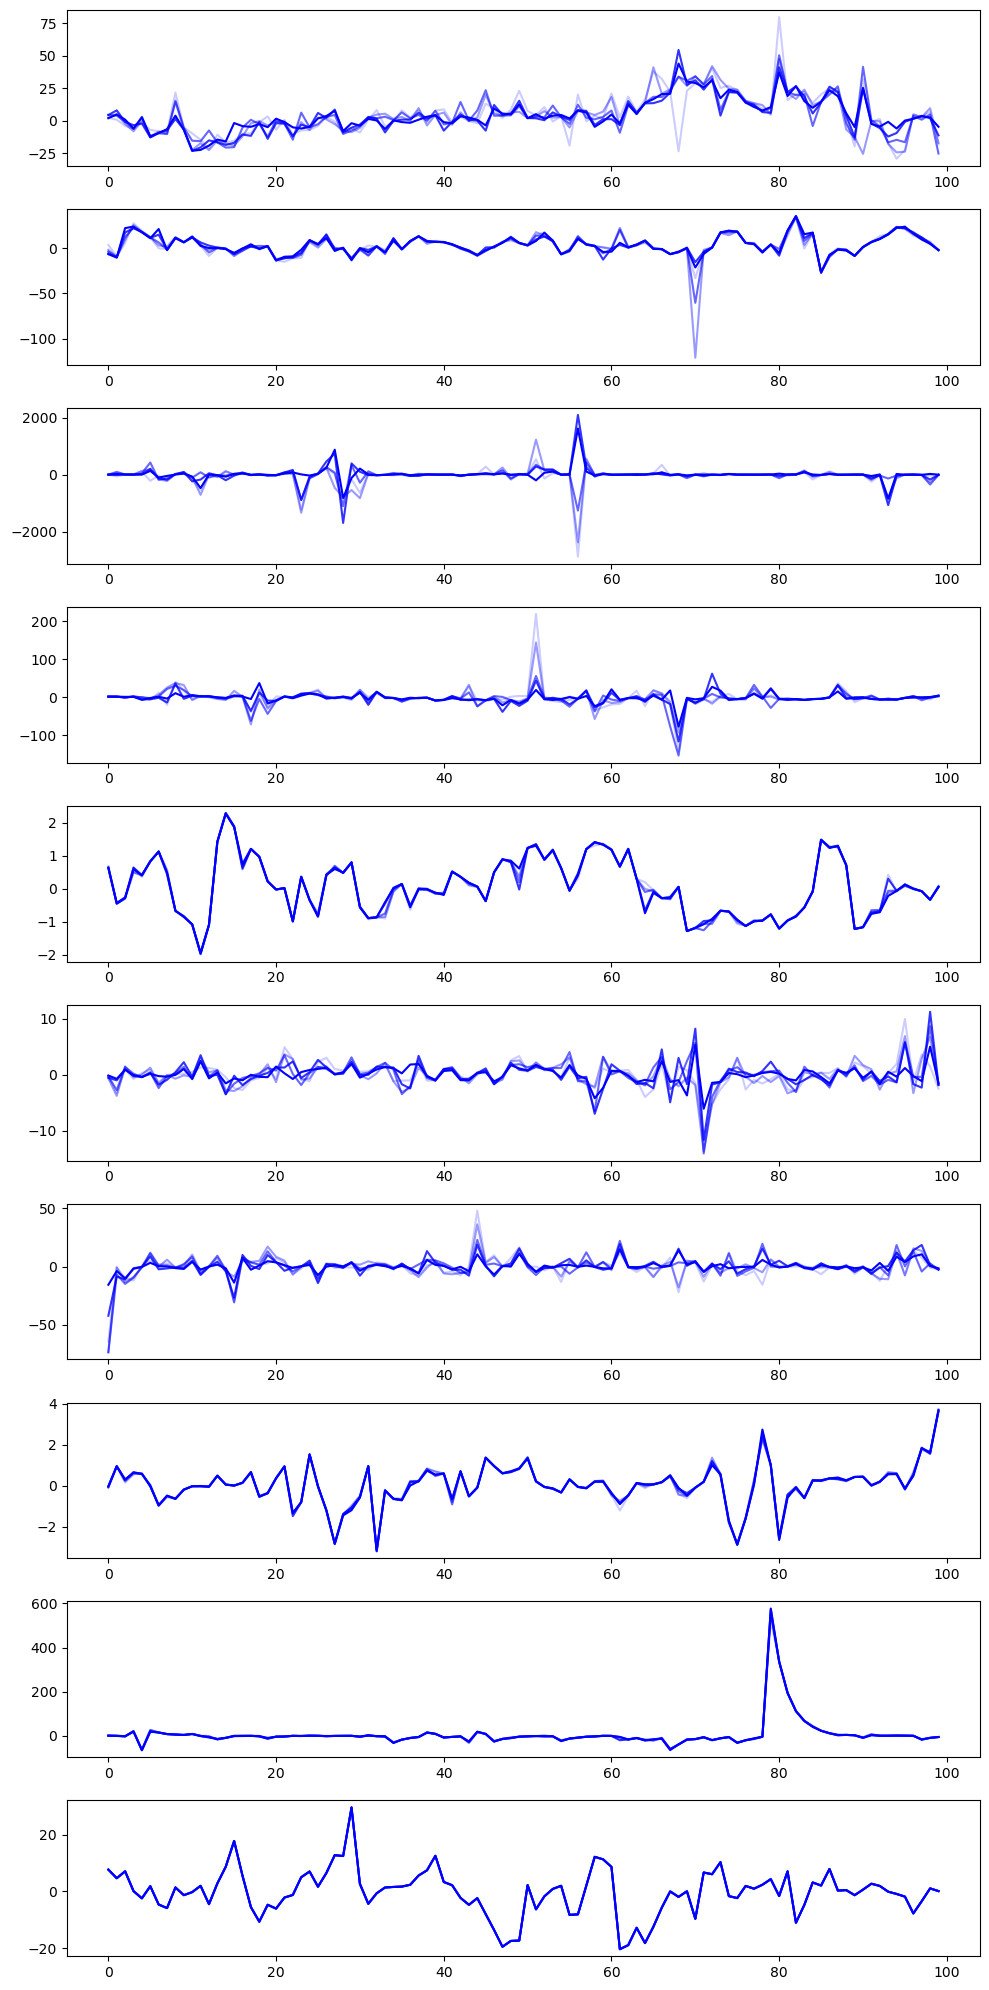

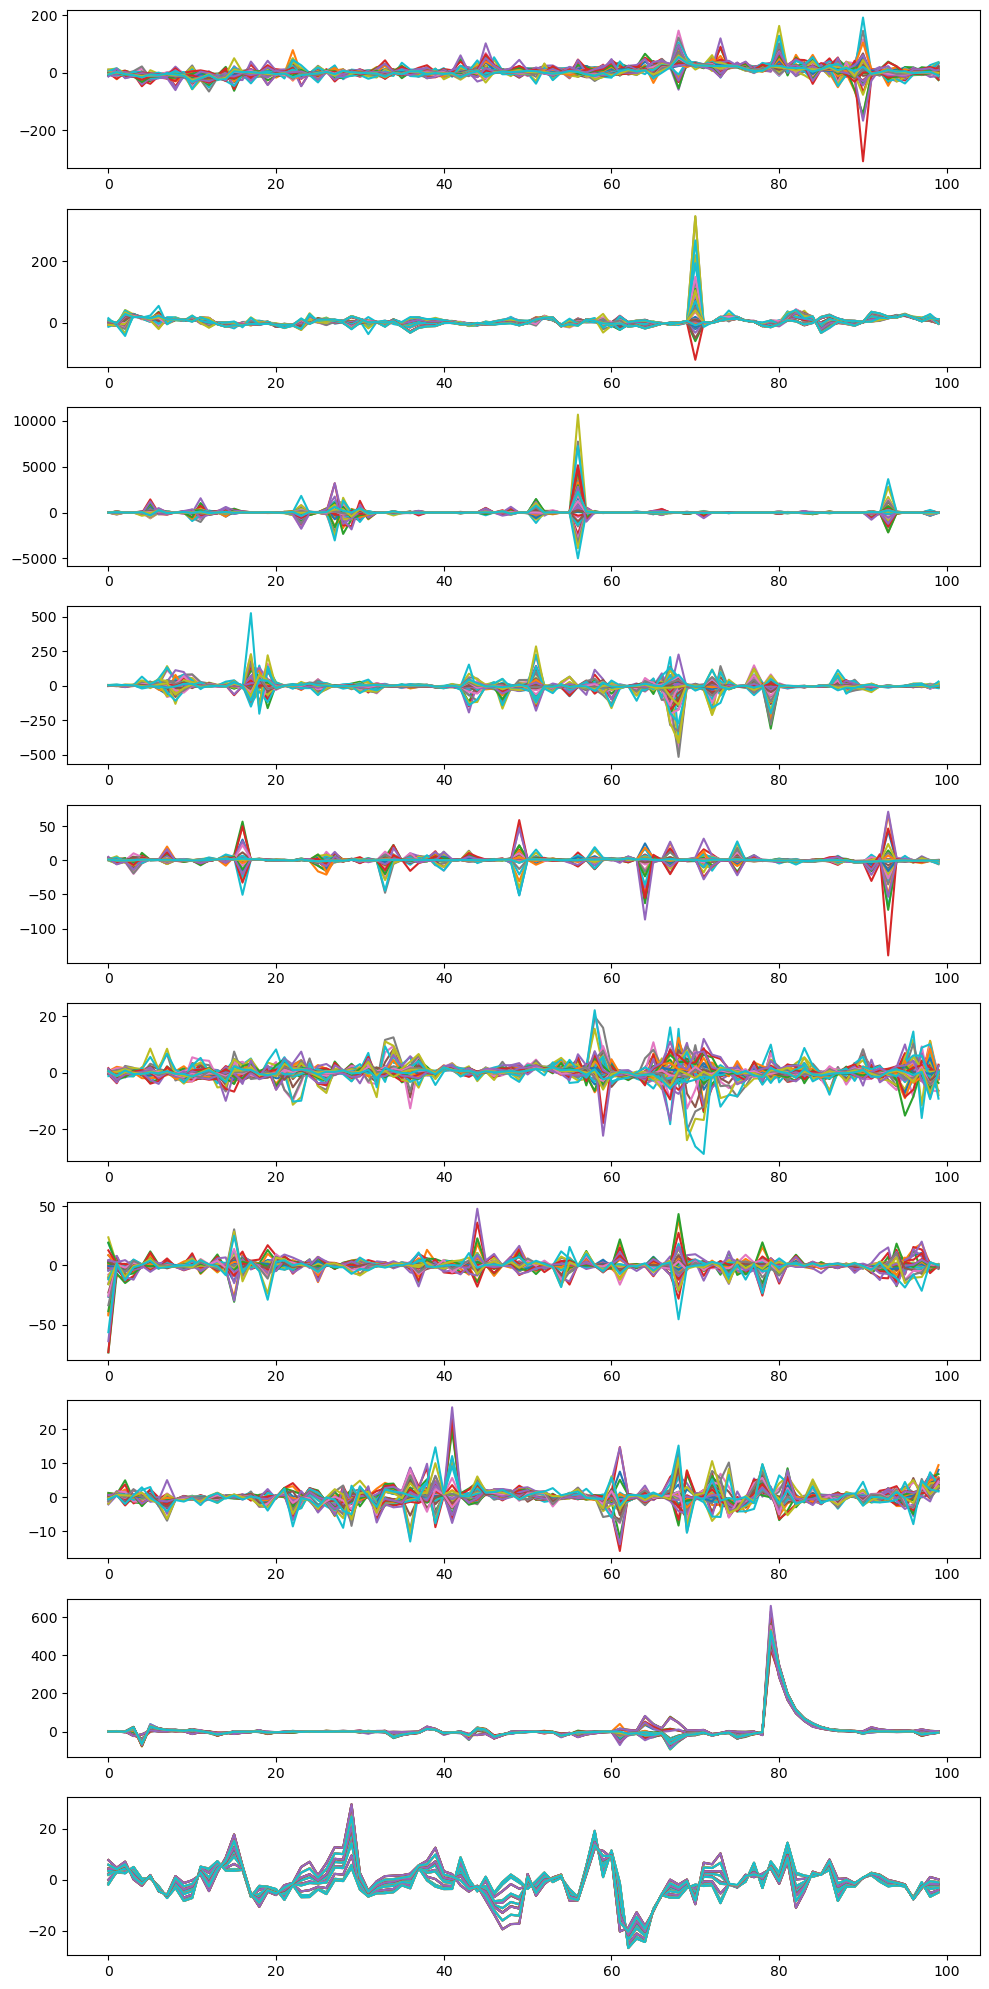

In [2]:
# Define a DFA model with specified parameter values to use for data generation
dfa_model = ARCHDFA(num_timesteps=100, num_series=10, num_horizons=5, num_factors=2, p=1, q=1,
                    sigma_factors_model='AR',loadings_constraint='simplex', 
                    Psi=0.5, h_rho = 0.8)

sample = dfa_model.sample(rng_key = jax.random.PRNGKey(42),
        condition={'intercept':jnp.zeros((10,1))})


# Draw a sample of size 10 from the model, specifying that the intercept is 0

t=jnp.linspace(0, 99, 100)
fig, ax = plt.subplots(10, 1, figsize = (10, 20), squeeze=False)
for i in range(10):
    for j in range(5):
        ax[i, 0].plot(t, sample['y'][i, :, 0, j], alpha = 1-0.2*j, color = 'blue')

plt.tight_layout()

t=jnp.linspace(0, 99, 100)
fig, ax = plt.subplots(10, 1, figsize = (10, 20), squeeze=False)
for i in range(10):
    for j in range(10):
        ax[i, 0].plot(t, sample['y'][i, :, j, :])

plt.tight_layout()
print(sample['y'][0, ].shape)

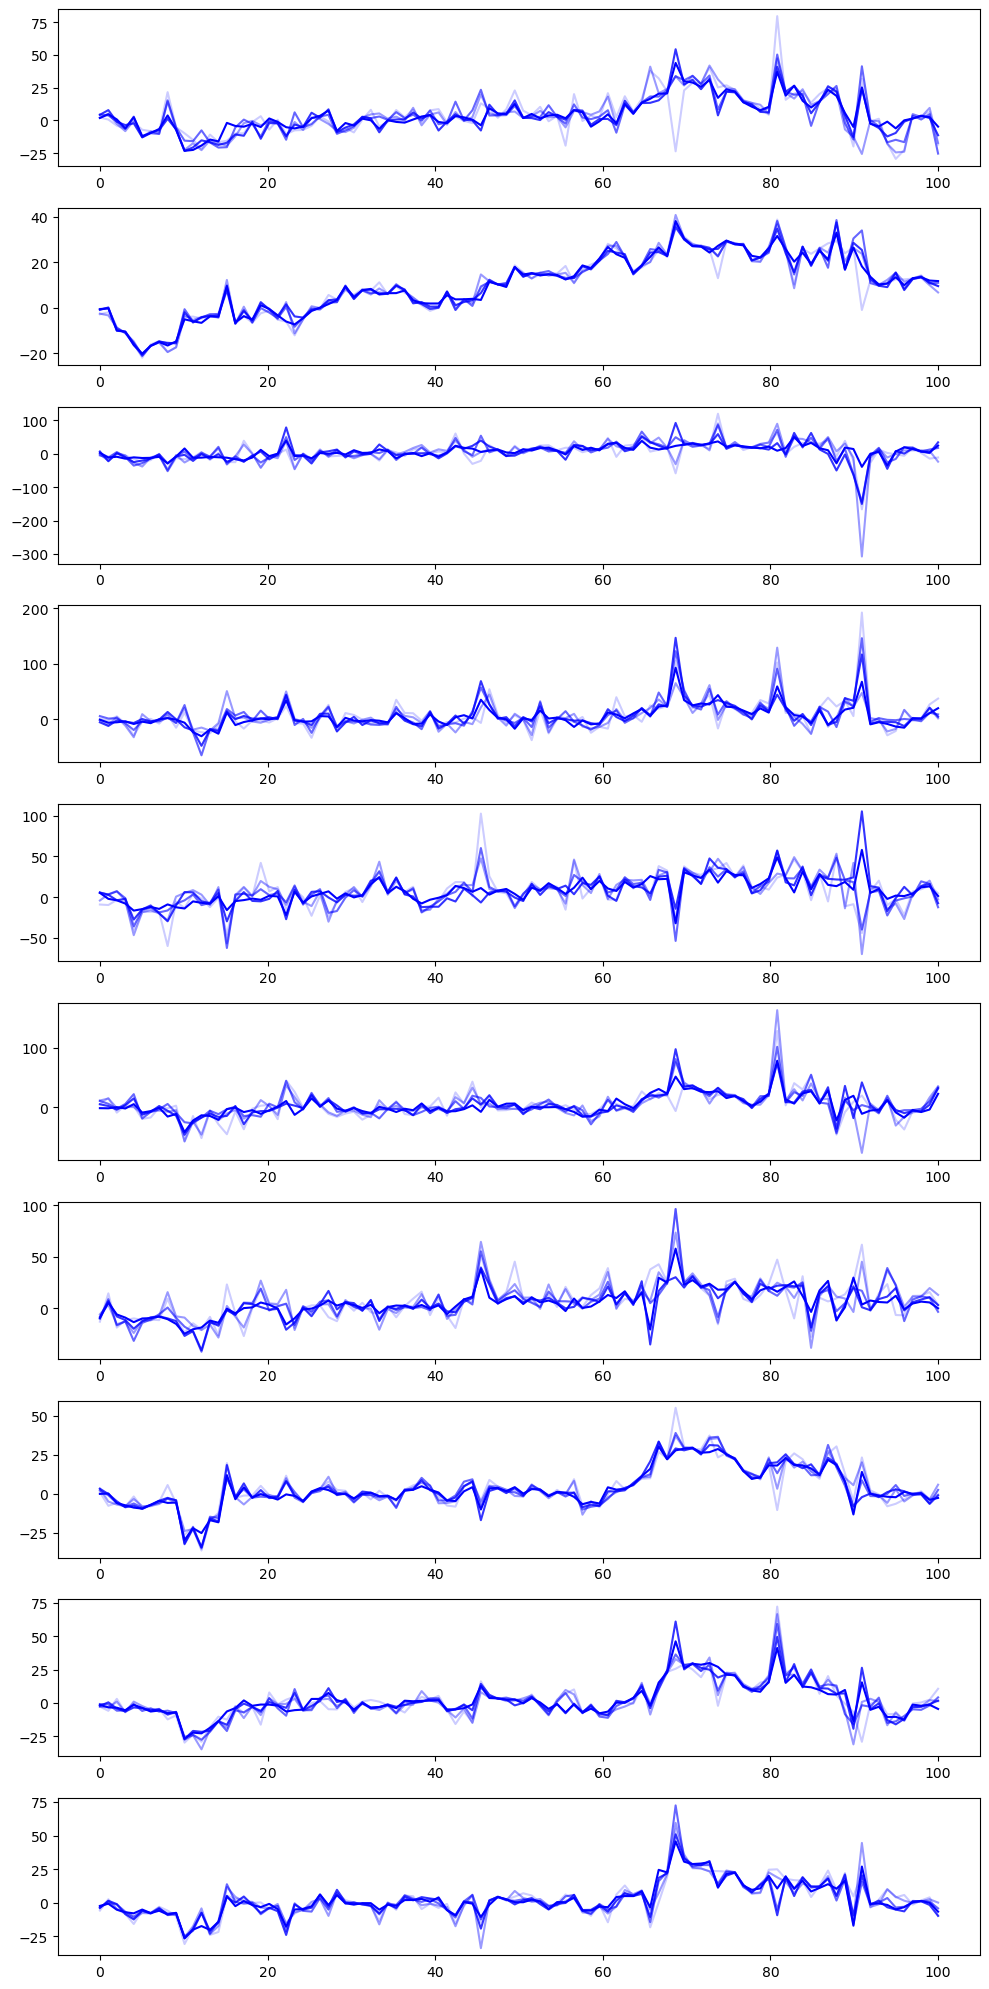

In [3]:
t=jnp.linspace(0, 100, 100)
fig, ax = plt.subplots(10, 1, figsize = (10, 20), squeeze=False)
for i in range(10):
    for j in range(5):
        ax[i, 0].plot(t, sample['y'][0, :, i, j], alpha = 1-0.2*j, color = 'blue')

plt.tight_layout()


In [4]:
# Fit the model to the first of the simulated series
mcmc_samples = dfa_model.fit(y=sample['y'][0, :, :, :],
                             rng_key=jax.random.PRNGKey(79942),
                             num_warmup=10000,
                             num_samples=10000,
                             num_chains=3)

/Users/dongahkim/Creative Cloud Files/epi/comparing-forecasting-performance/archdfa/archdfa.py:407: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = numpyro.infer.MCMC(


(100, 10, 5)
(100, 10, 5)


  0%|          | 0/20000 [00:00<?, ?it/s]

(100, 10, 5)


sample: 100%|██████████| 20000/20000 [12:24<00:00, 26.87it/s, 383 steps of size 2.83e-02. acc. prob=0.95] 


(100, 10, 5)
(100, 10, 5)


sample: 100%|██████████| 20000/20000 [08:46<00:00, 37.96it/s, 127 steps of size 4.05e-02. acc. prob=0.88]


(100, 10, 5)
(100, 10, 5)


sample: 100%|██████████| 20000/20000 [09:49<00:00, 33.93it/s, 127 steps of size 3.05e-02. acc. prob=0.92]



MCMC elapsed time: 1870.6266570091248


In [5]:
dfa_model.mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
        ARVar_mu[0,0]      0.98      0.16      0.98      0.72      1.24   2326.90      1.00
           alpha[0,0]      0.16      0.12      0.14      0.00      0.33   9203.67      1.00
           beta0[0,0]      1.23      0.29      1.23      0.78      1.72    656.56      1.00
           beta1[0,0]      0.41      0.15      0.40      0.15      0.65   2482.18      1.00
 factor_loadings[0,0]      0.57      0.20      0.67      0.25      0.78      1.58      4.11
 factor_loadings[0,1]      0.43      0.20      0.33      0.22      0.75      1.58      4.11
 factor_loadings[1,0]      0.36      0.39      0.14      0.00      0.95      1.53      6.50
 factor_loadings[1,1]      0.64      0.39      0.86      0.05      1.00      1.53      6.50
 factor_loadings[2,0]      0.42      0.24      0.30      0.15      0.81      1.60      3.74
 factor_loadings[2,1]      0.58      0.24      0.70      0.19      0.85      1.

In [7]:
print(jnp.percentile(mcmc_samples['intercept'], jnp.array([5, 95])))
print(jnp.percentile(mcmc_samples['intercept'], jnp.array([2.5, 97.5])))

[-1.6430882  1.7346131]
[-2.0231543  2.3644655]


### - posterior predictive check 

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior. PPC is an analysis of how closely the data generated by the model matches the actual data. If the model fits well, the replicated data generated by the model should be similar to the observed data. Use the `sample` function by adding the sampling values from the posterior distributions to `condition`.

In [8]:
print(mcmc_samples['intercept'].shape)
print(mcmc_samples['factor_loadings'].shape)
mcmc_samples
list(mcmc_samples) 

(30000, 1)
(30000, 10, 2)


['ARVar_mu',
 'alpha',
 'beta0',
 'beta1',
 'factor_loadings',
 'factors',
 'intercept',
 'log_sigma_eps_t',
 'log_sigma_eta',
 'log_sigma_eta_0',
 'phi',
 'sigma_eps_l',
 'sigma_nu',
 'sigma_zeta',
 'z_0']

In [9]:
PPC = dfa_model.sample(rng_key = jax.random.PRNGKey(42),
        condition={'intercept':mcmc_samples['intercept'],
        'ARVar_mu':mcmc_samples['ARVar_mu'], 'alpha':mcmc_samples['alpha'],
        'beta0':mcmc_samples['beta0'], 'beta1':mcmc_samples['beta1'],
        'phi':mcmc_samples['phi'],
        'sigma_eps_l':mcmc_samples['sigma_eps_l'], 'sigma_nu':mcmc_samples['sigma_nu'],
        'sigma_zeta':mcmc_samples['sigma_zeta']})

print(list(PPC))

PPC['y'].shape

['factor_loadings', 'factors', 'log_sigma_eps_t', 'log_sigma_eta', 'log_sigma_eta_0', 'y', 'z_0']


(30000, 100, 10, 5)

(30000,)


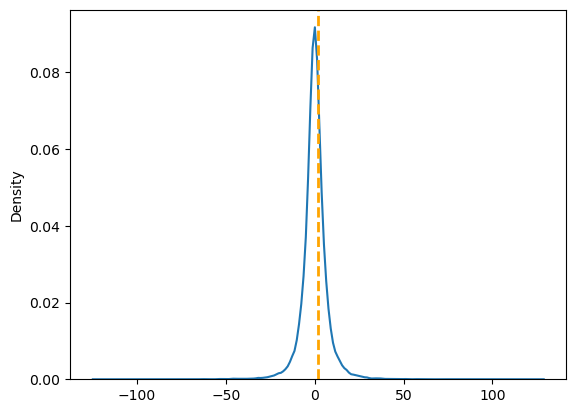

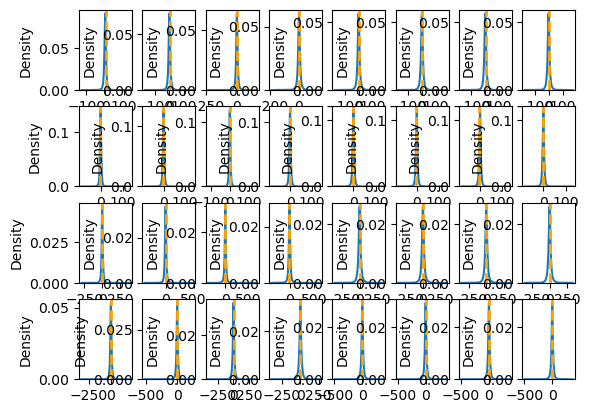

In [10]:
print(PPC['y'][:,0,0,0].shape)
sns.kdeplot(PPC['y'][:,0,0,0])
plt.axvline(sample['y'][0,0,0,0], c='orange', ls='--', lw=2)



plt.figure(0)
plots = []
for i in range(4):
    for j in range(8):
        ax = plt.subplot2grid((4,8), (i,j))
        ax = sns.kdeplot(PPC['y'][:,0,i,j])
        ax.axvline(sample['y'][0,0,i,j], c='orange', ls='--', lw=2)
plt.show()